In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
import hpc_reports
#
def running_mean(X,n=10):
    return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
#
#data_file_name = 'data/sacct_serc_20200622.out'
#data_file_name = 'data/sacct_serc_20200724.pkl'

In [3]:
# load_pickle=True
# pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
# #
# if load_pickle:
#     with open(pkl_name, 'rb') as fin:
#         sacct_mazama=pickle.load(fin)
#     #
# else:
#     sacct_mazama = hpc_lib.SACCT_data_handler(data_file_name=data_file_name)
#     #
    
#     with open(pkl_name, 'wb') as fout:
#             #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
#             out_pkl = pickle.dump(sacct_mazama, fout)

In [5]:
# n_cpus:
n_cpus = 1
if 'SLURM_JOB_ID' in os.environ.keys():
    # running in SLURM...
    if 'SLURM_JOB_CPUS_PER_NODE' in os.environ.keys():
        n_cpus = max( int(os.environ['SLURM_JOB_CPUS_PER_NODE']), 1)
    else:
        n_cpus = 1
else:
    n_cpus = min(8, mpp.cpu_count())
#
# or specify here:
n_cpus = 4
#
print('** n_cpus: ', n_cpus)

** n_cpus:  4


In [6]:
#end_dtm = dtm.datetime.now()+dtm.timedelta(days=1)
end_dtm = dtm.datetime(2022,2,2)
sacct_h5_file = f'sacct_data/serc_sacct_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
#start_date = '2021-04-15'
#end_date   = '2021-05-15'
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=180)
print('*** dates: {} - {}'.format(start_date, end_date))
#
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating new SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    print(f'** {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=None, partition='serc', start_date=str(start_date),
                                          n_cpu=n_cpus,
                                          end_date=str(end_date), keep_raw_data=False)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** dates: 2021-08-06 - 2022-02-02
*** Creating new SACCT object from HDF5 sacct_data/serc_sacct_20220202.h5
** sacct_data/serc_sacct_20220202.h5
*** DEBUG: updating column [index], type=<i8
*** DEBUG: updating column [User], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Group], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [GID], type=('|S6', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobName], type=('|S86', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobID], type=('|S20', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobIDRaw], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Partition], type=('|S4', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [State], type=('|S19', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Timelimit], type=<f8
*** DEBUG: updating column [NCPUS], type=<i8
*** DEBUG: updating column [NNodes], type=<i8
*** DEBUG: updating column [Submit], type=<f

In [7]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl]))
                                                   for cl in ['Start', 'Submit'] ]))
print('** cols: ', SACCT_obj.jobs_summary.dtype.names)

*** max_submit: 2022-02-01 12:34:18+00:00, max_start: 2022-02-01 12:33:55+00:00
** cols:  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')


In [8]:
# NOTE: add this to the __init__. would be nice to refactor the code a bit to better handle inheritance.
if not 'chunk_size' in SACCT_obj.__dict__.keys():
    print('*** assigning chunk_size: ', chunk_size)
    SACCT_obj.chunk_size=1000

In [9]:
#
cpu_usage = SACCT_obj.active_jobs_cpu()
#
bin_size=7
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=bin_size, t_min=None)

*** DEBUG: 5000, None
*** DEBUG: 26, 7


In [10]:
print('** ', len(cpu_usage))
print('** \n', cpu_usage[0:10])

**  5000
** 
 [(18842.8159838 , 1., 72.) (18842.85233403, 1., 72.)
 (18842.88868426, 1., 72.) (18842.9250345 , 1., 72.)
 (18842.96138473, 1., 72.) (18842.99773496, 1., 72.)
 (18843.03408519, 1., 72.) (18843.07043543, 1., 72.)
 (18843.10678566, 1., 72.) (18843.14313589, 1., 72.)]


<ipython-input-11-873d9167c620>:2: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-11-873d9167c620>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-11-873d9167c620>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


[Text(18825.0, 0, '2021-7-17'),
 Text(18850.0, 0, '2021-8-11'),
 Text(18875.0, 0, '2021-9-5'),
 Text(18900.0, 0, '2021-9-30'),
 Text(18925.0, 0, '2021-10-25'),
 Text(18950.0, 0, '2021-11-19'),
 Text(18975.0, 0, '2021-12-14'),
 Text(19000.0, 0, '2022-1-8'),
 Text(19025.0, 0, '2022-2-2'),
 Text(19050.0, 0, '2022-2-27')]

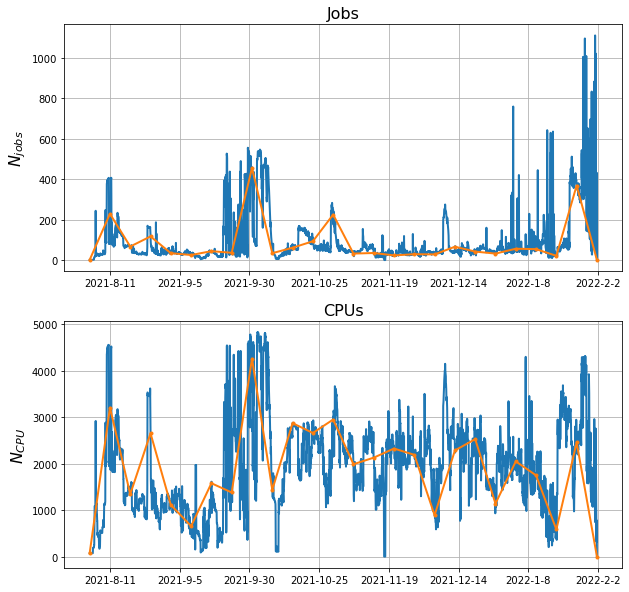

In [11]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.')
#

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
# fix_to_ascii(s)
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(s.get_text()))) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



In [12]:
# def time_bin_aggregates(XY, bin_mod=24, qs=[.25, .5, .74]):
#     XY=numpy.array(XY)
#     if XY.shape[0]==2:
#         X = XY[0,:]
#         Y = XY[1:]
#     else:
#         X = XY[:,0]
#         Y = XY[:,1]
#     #
#     #X_mod = ((X*bin_mod)%bin_mod).astype(int)
#     X_mod = ((X%1.)*bin_mod).astype(int)
#     #
#     stats_output=[]
#     for x in numpy.unique(X_mod):
#         ix = X_mod==x
#         this_Y = Y[ix]
#         stats_output += [numpy.append([x, numpy.mean(this_Y), numpy.std(this_Y)],
#                                       numpy.quantile(this_Y, qs))]
#     #
#     return numpy.core.records.fromarrays(numpy.array(stats_output).T, dtype=[('x', '>f8'), ('mean', '>f8'),
#                                                         ('stdev', '>f8')] + 
#                                          [('q_{}'.format(q), '>f8') for q in qs])
# #

    

<ipython-input-13-70aae9fac9e3>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('121')
<ipython-input-13-70aae9fac9e3>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('122')


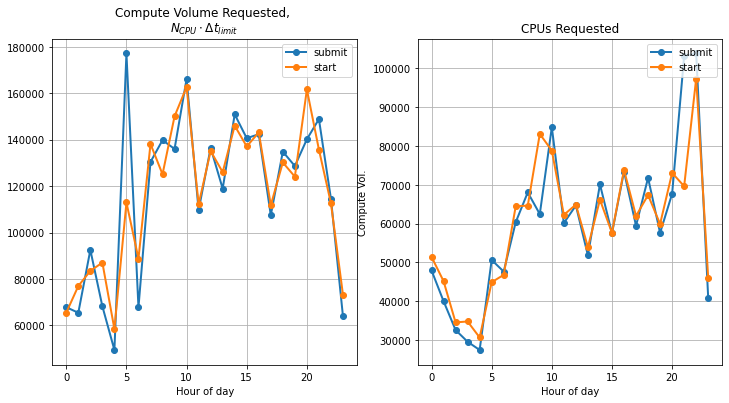

In [13]:
qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax2.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

Text(0.5, 0.98, 'Instantaneous Usage')

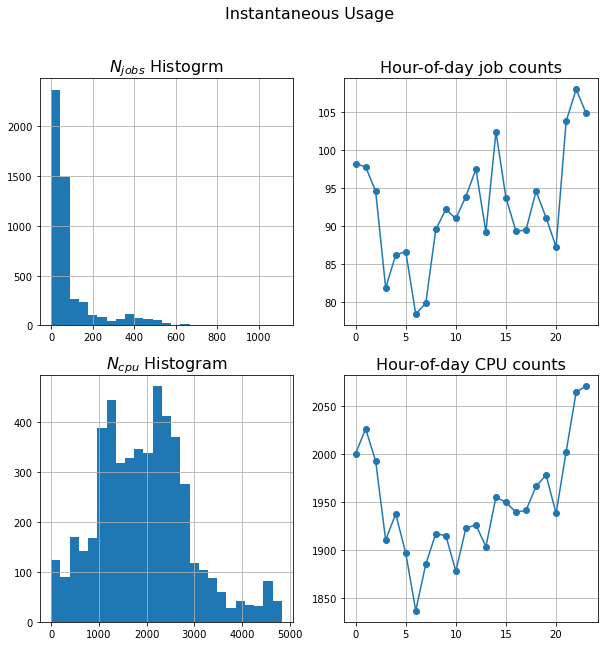

In [14]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
axs = [ax1, ax2, ax3, ax4]
[ax.grid() for ax in axs]
#
cpu_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_cpu']]).T)
jobs_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_jobs']]).T)

hh1 = ax1.hist(sorted(cpu_usage['N_jobs'])[0:int(1.0*len(cpu_usage))], bins=25, cumulative=False)
ax2.plot(jobs_hourly['x'], jobs_hourly['mean'], ls='-', marker='o')

hh3 = ax3.hist(cpu_usage['N_cpu'], bins=25)
ax4.plot(cpu_hourly['x'], cpu_hourly['mean'], ls='-', marker='o')

#ax1.set_ylim(-5., 200)
ax1.set_title('$N_{jobs}$ Histogrm', size=16)
ax2.set_title('Hour-of-day job counts', size=16)
ax3.set_title('$N_{cpu}$ Histogram', size=16)
ax4.set_title('Hour-of-day CPU counts', size=16)
#
plt.suptitle('Instantaneous Usage', size=16)

In [15]:
weekly_hours = SACCT_obj.get_cpu_hours(bin_size=7, n_points=5000)

daily_hours = SACCT_obj.get_cpu_hours(bin_size=1, n_points=5000)

<ipython-input-16-182b562b06b0>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lbls)


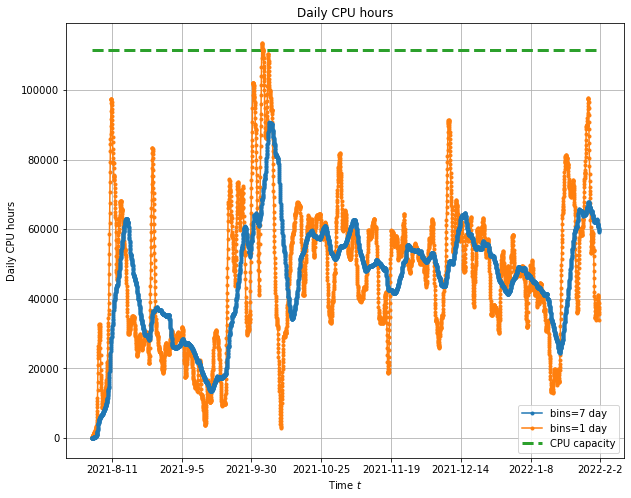

In [16]:
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(weekly_hours['time'], weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)
#
#ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*14*24*24, ls='--', lw=3.)
#ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*12*24*24, ls='--', lw=3.)
#
n_cpus_serc = 32*104 + 128*8 + 24*12
n_cpus_serc_gpus = n_cpus_serc + 128*6 + 24*2
ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*24*n_cpus_serc, ls='--', lw=3.,
         label='CPU capacity')
#ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*24*n_cpus_serc_gpus, ls='--', lw=3.)




#
fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(s.get_text()))) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax1.set_xticklabels(lbls)
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Daily CPU hours')
ax1.set_title('Daily CPU hours')
#
ax1.legend(loc=0)

In [17]:
print('** dtype:\n', SACCT_obj.jobs_summary.dtype)
#
#user_cols  = ['Timelimit', 'NCPUS', 'NNodes', 'TotalCPU','NTasks']
#user_types = ['>f8', '>i8', '>i8', '>f8', '>i8', '>f8']

user_cols = ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']
user_types = ['>i8', '>i8', '>f8', '>f8']
#
user_aggs = numpy.zeros( shape=[len(numpy.unique(SACCT_obj.jobs_summary['User'])),],
                        dtype={'names':user_cols, 'formats':user_types })
#
ix = {usr:numpy.where(SACCT_obj.jobs_summary['User']==usr)[0] 
      for usr in numpy.unique(SACCT_obj.jobs_summary['User'])}
#

** dtype:
 [('index', '<i8'), ('User', 'S8'), ('Group', 'S8'), ('GID', 'S6'), ('JobName', 'S86'), ('JobID', 'S20'), ('JobIDRaw', 'S8'), ('Partition', 'S4'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S50'), ('AllocTRES', 'S64'), ('JobID_parent', 'S20')]


In [18]:
print('*** ', user_aggs.shape, user_aggs.dtype)
print('*** ', user_cols)
user_names = numpy.unique(SACCT_obj.jobs_summary['User'])
for k,user in enumerate(user_names):
    #print('** ', [numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    #
    vals = [numpy.sum( numpy.max([numpy.zeros(len(ix[user])), SACCT_obj.jobs_summary[cl][ix[user]]], axis=0) ) 
                      for cl in user_cols[:-1]]
    vals += [numpy.sum(SACCT_obj.jobs_summary['Elapsed'][ix[user]]*24. * SACCT_obj.jobs_summary['NCPUS'][ix[user]])]
    #print('** ix: ', ix[user])
    #vals = [numpy.sum( (SACCT_obj.jobs_summary[cl][ numpy.array(ix[user])] ) )
    #        for cl in user_cols]
    #print('** vals: ', vals)
    
    #user_aggs[user_cols][k] = tuple([numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    
    user_aggs[user_cols][k] = tuple( vals )
    #user_aggs[user_cols][k] = tuple(vals)



***  (100,) [('NCPUS', '>i8'), ('NNodes', '>i8'), ('Elapsed', '>f8'), ('Comp_Vol', '>f8')]
***  ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']


In [19]:
# print('** user, {}'.format(user_cols ) )
# for nm,rw in zip(user_names, user_aggs):
#     print('** {}: {}, '.format(nm,rw))

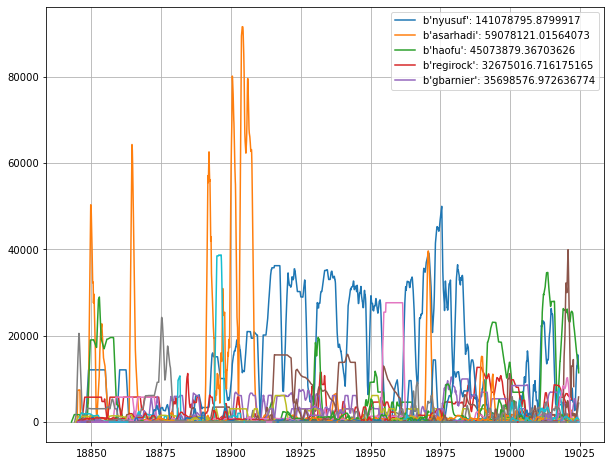

In [20]:
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()
for k,usr in enumerate(user_names[numpy.argsort(user_aggs['Comp_Vol'])[::-1]]):
    cpuh = SACCT_obj.get_cpu_hours(bin_size=1.0, jobs_summary=SACCT_obj.jobs_summary[ix[usr]])
    ax.plot(cpuh['time'], cpuh['cpu_hours'], label=('{}: {}'.format(usr, numpy.sum(cpuh['cpu_hours']) )
                                                    if k<5 else None) )
ax.legend(loc=0)

<ipython-input-21-ba0d35d16ea0>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('121')
<ipython-input-21-ba0d35d16ea0>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('122')


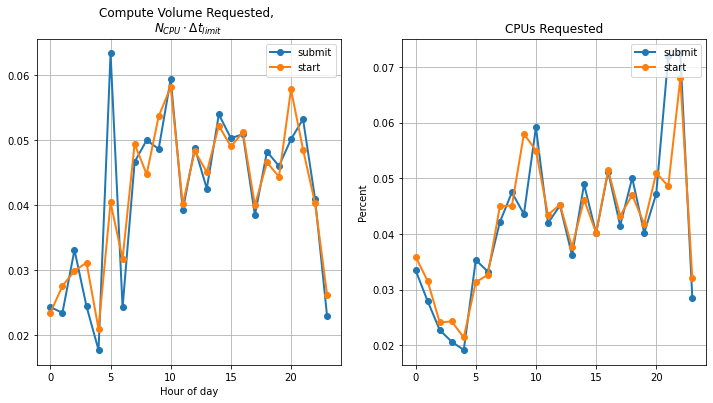

In [21]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time']),
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))

ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time']),
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time'])))
#
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/numpy.sum(comp_vol_submit['cpus']), ls='-', marker='o', lw=2., label='submit')
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/numpy.sum(comp_vol_start['cpus']), ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Percent')

ax2.set_title('CPUs Requested')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

***  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')


Text(0.5, 1.0, '(Cumulative)')

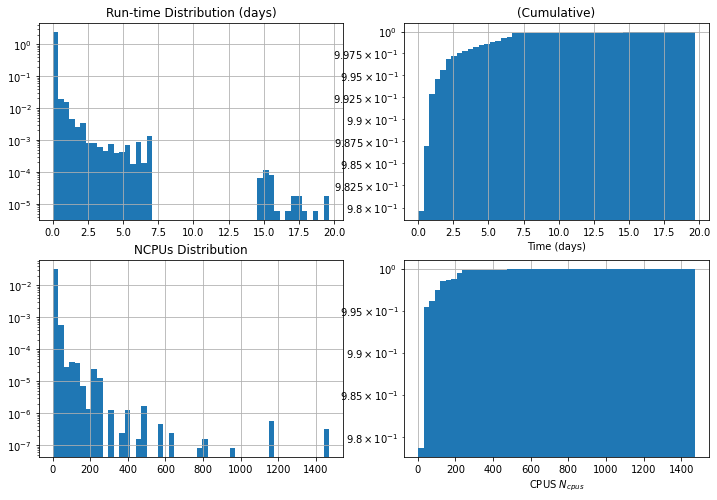

In [22]:
# compute some distributions:
print('*** ', SACCT_obj.jobs_summary.dtype.names)
run_times = SACCT_obj.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
#ax1a.set_yscale('log')
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, density=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, density=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True)
hh22 = ax4.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [23]:
print('** ', len(run_times), len(SACCT_obj.jobs_summary['NCPUS']))

**  429805 429810


In [24]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(SACCT_obj.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


*** quantiles for t=2,7,14 days: 0.995677109386815, 0.9995020997894394, 0.9998650550831191
*** N_24/N=0.9785460848524331


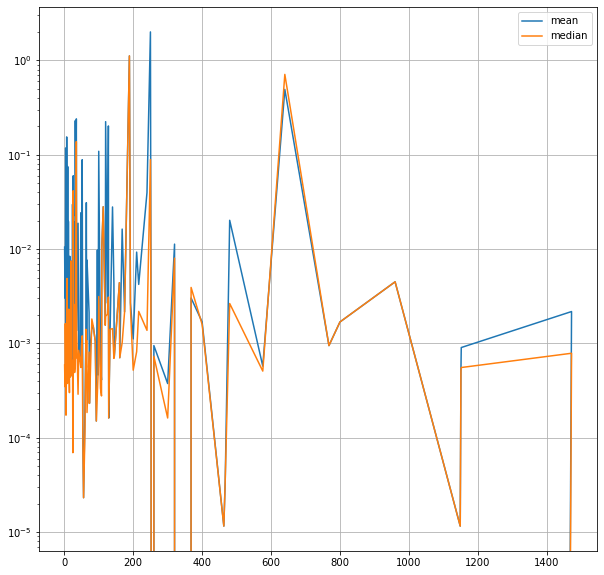

In [25]:
wait_stats = SACCT_obj.get_wait_stats()
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean'], ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median'], ls='-', label='median')
#
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')
ax1.legend(loc=0)

*** DEBUG: 109, 7
***  ['2019-10-31', '2020-2-8', '2020-5-18', '2020-8-26', '2020-12-4', '2021-3-14', '2021-6-22', '2021-9-30', '2022-1-8', '2022-4-18']


<ipython-input-26-ff8e6c5bdb1b>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-26-ff8e6c5bdb1b>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-26-ff8e6c5bdb1b>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


Text(0.5, 0.98, 'Mazama Activity, $\\Delta t_{binsize}=7$ days')

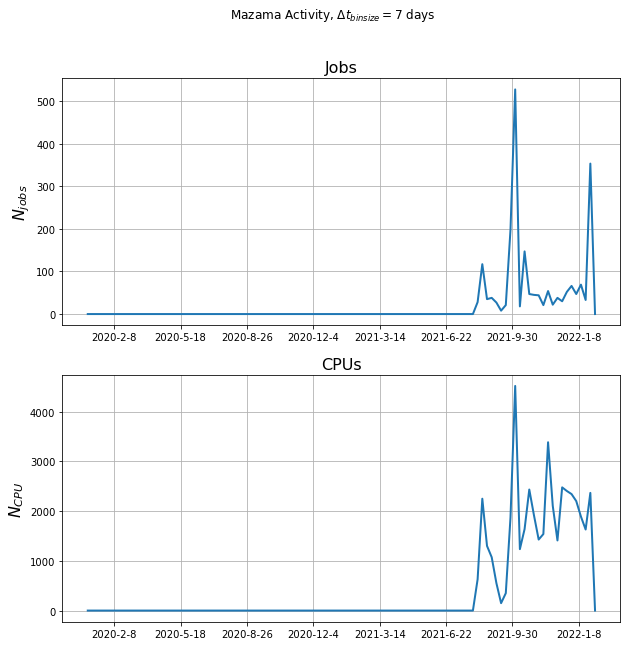

In [26]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
bin_size=7
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=bin_size, t_min=t0)
#
fg = plt.figure(figsize=(10,10))
plt.suptitle('Weekly Usage')
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)
#
plt.suptitle('Mazama Activity, $\Delta t_{{binsize}}={}$ days'.format(bin_size))


***  ['1969-12-31', '1969-12-31', '1969-12-31', '1970-1-1', '1970-1-1', '1970-1-1', '1970-1-1']


<ipython-input-27-794c851249f7>:30: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-27-794c851249f7>:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-27-794c851249f7>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


[Text(-0.06, 0, '1969-12-31'),
 Text(-0.039999999999999994, 0, '1969-12-31'),
 Text(-0.019999999999999997, 0, '1969-12-31'),
 Text(0.0, 0, '1970-1-1'),
 Text(0.020000000000000004, 0, '1970-1-1'),
 Text(0.04000000000000001, 0, '1970-1-1'),
 Text(0.06, 0, '1970-1-1')]

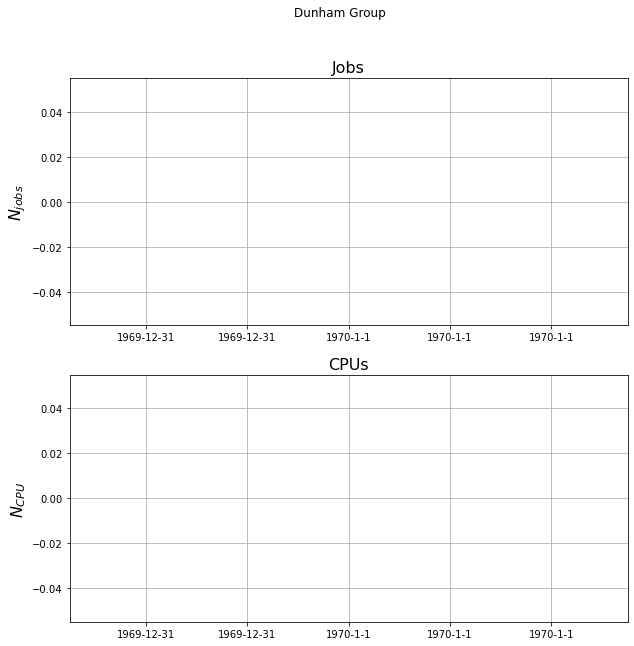

In [27]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
# and get a list of users to construct an index:
# $ finger dunham
# Login: edunham         Name: Eric Dunham
# Directory: /home/edunham             Shell: /bin/bash
# Never logged in.
# No mail.
# No Plan.
# [rcwhite@cees-mgmt0 ~]$ id edunham
# uid=60367(edunham) gid=100(users) groups=100(users),203(tgp),70137(fs-erd)
# [rcwhite@cees-mgmt0 ~]$ getent group | grep tgp
# tgp:*:203:ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,
# gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,schu3,
# lbruhat,kallison,labraha2,kcoppess,edunham
#
users = 'ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,\
gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,\
schu3,lbruhat,kallison,labraha2,kcoppess,edunham'.split(',')
users = [s for s in users if not s in ('myoder96', 'dennis')]
#print('** users: ', users)
#
ix = numpy.array([s in users for s in SACCT_obj.jobs_summary['User'] ])
#print('** ', (sacct_mazama.jobs_summary[ix])[0:20] )
#
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=7., t_min=t0, ix=ix)
#
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')
#
plt.suptitle('Dunham Group')
ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text().replace(chr(8722), '-'))) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)

In [28]:
# if True:
#     with open(data_file_name, 'r') as fin:
#         header_rw = fin.readline()
#         print('*** ', header_rw)

#     headers = header_rw.split('|')
#     k_group = headers.index('Group')
#     k_gid = headers.index('GID')
#     #
    
#     with open(data_file_name, 'r') as fin:
#         for k,rw in enumerate(fin):
#             #if 'dunham' in rw: print('** ', rw)
#             #if 'dunham' in rw:
#             #    rws = rw.split('|')
#             #    print('** ', rws[k_group], rws[k_gid])
#             if 'Partition_Limit' in rw:
#                 print('** ', rw)
#                 k+=1
#                 if k>10: break



In [29]:
print('** ',SACCT_obj.jobs_summary.dtype.names)
print('** ', mpd.num2date(SACCT_obj.jobs_summary['Submit'][-1]))

**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')
**  2022-02-01 12:33:55+00:00


In [30]:
dta = SACCT_obj.jobs_summary.copy()
dta.sort(order='Submit')

## Drafts of some reports
- We have a couple reports already made. Let's start with those.
- Even for those reports, we'll want to modify the inputs, for example to specify all Earth users/groups, not juust look at the `serc` partition.


In [31]:
### Report(s)
#
# first, we need to make groups.
# groups who can access serc:
# (base) [myoder96@sh01-ln01 login ~]$ scontrol show partition serc | grep Allow
#   AllowGroups=sh_s-ees,sh_sysadm AllowAccounts=ALL AllowQos=normal,high_p,system
#
# so all permissions are consolidated to the sh_s-ees group
# to get users in a group:
# USERS=`getent passwd | awk -F: -v g=$(id -g $PI_SUNET) '$4==g {print $1}'`
#. but this does not seem to work for the sh_s-ees group
# we can use id to get secondary groups (we'll need to pares...), for example,
# $ (base) [myoder96@sh01-ln01 login ~/Codes/cees_scripts]$ id myoder96
# uid=362778(myoder96) gid=32264(ruthm) groups=99001(sh_users),98013(sh_sw-stata),98008(sh_sw-schrodinger),97002(sh_s-ees),97005(sh_s-hns),1007582(oak_p-cees-backup),1008811(oak_s-ees),32264(ruthm)
# this should do it:
# getent group sh_s-ees
# then maybe just parse in Python...

In [32]:
# PI_groups = hpc_lib.get_PI_groups_from_groups(groups='sh_s-ees')
# #
# for ky,vl in PI_groups.items():
#     print('** {}, {}'.format(ky,vl))
#     #
# #
# SACCT = hpc_lib.SACCT_data_direct(partition='serc', start_date='2021-01-01', end_date='2021-06-03',
#                                   keep_raw_data=False)
# #
# rpt = hpc_lib.SACCT_groups_analyzer_report(Short_title='SERC HPC Analytics', 
#                 Full_title='HPC Analytics Breakdown for Stanford Earth, Sherlock SERC',
#                 out_path='output/SERC_analytics_20210602', tex_filename='SERC_HPC_analytics.tex',
#                                            groups=PI_groups, SACCT_obj=SACCT)


### CEES Sherlock report(s)
- Let's just get into this... What we need:
- Standard(ish) report of SERC (and other) partition(s) usage
- Mostly same standard report for each active PI group

#### Standard report:
- jobs,cpus
- cpu-hours
- Time-of-Day, Day-of-week usage
- 

#### Basic workflow:
- Get full SACCT data for `serc` partition
- Run report on partition usage
- Get active groups (group name + users?)
- Fetch new SACCT_obj for each group
- Run report for each group.

In [33]:
#SACCT_obj.write_hdf5('sacct_data/serc_2021_12_01_2022_01_31.h5')

keys:  dict_keys(['All'])
*** DEBUG: group: All
*** DEBUG: 5000, None


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:1850: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [All] Slide_1 added??:: 3


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:1228: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


*** Slide_2 added??::  4
** adding slide: slide_2
** adding slide: slide_3


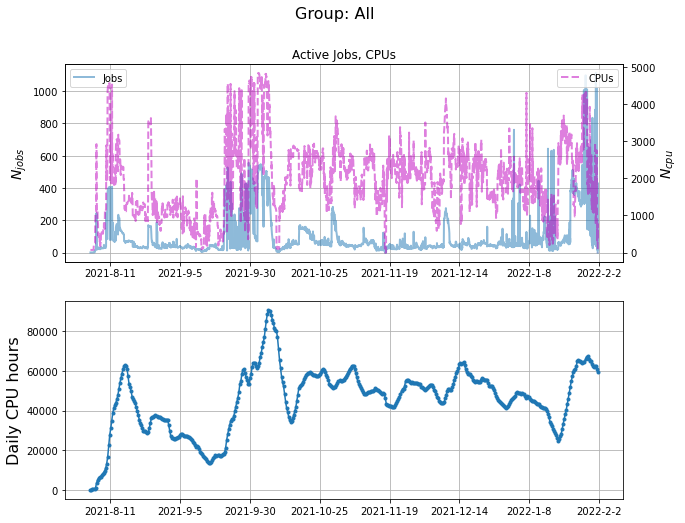

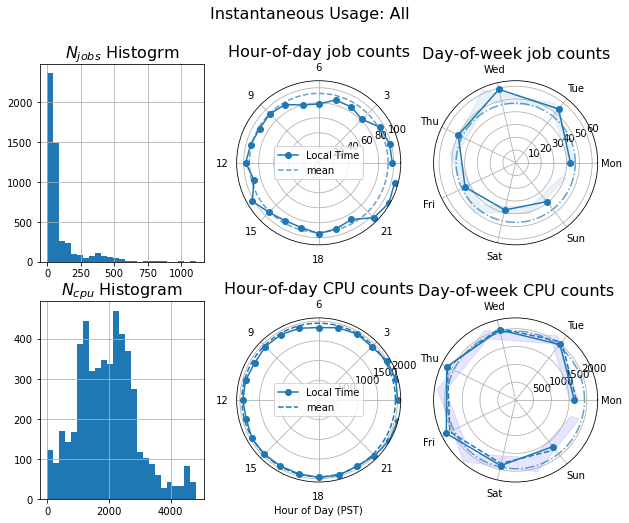

In [34]:
# SACCT_obj = hpc_lib.SACCT_data_direct(partition='serc', start_date='2021-12-01', end_date='2022-01-31',
#                                   keep_raw_data=False)
# SACCT_obj.write_hdf5('sacct_data/serc_2021_12_01_2022_01_31.h5')

serc_report = hpc_lib.SACCT_groups_analyzer_report(Short_title='SERC Analytics', Full_title='SERC HPC analytics',
                                                  SACCT_obj=SACCT_obj,
                                                  out_path='output/SERC_analytics_20220121',
                                                   tex_filename='SERC_HPC_analytics.tex'
                                                  )



*** DEBUG: 5000, None


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:2061: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** DEBUG: 5000, None


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:1228: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


*** DEBUG: 5000, None


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:1228: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


** adding slide: slide_2
** adding slide: slide_3
** adding slide: slide_4


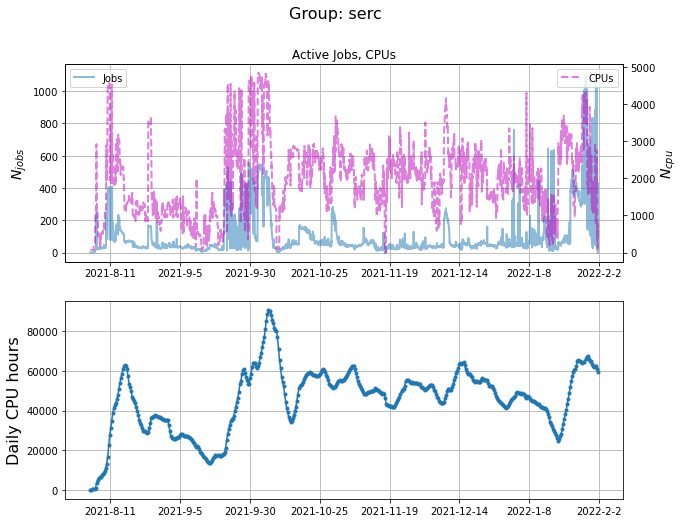

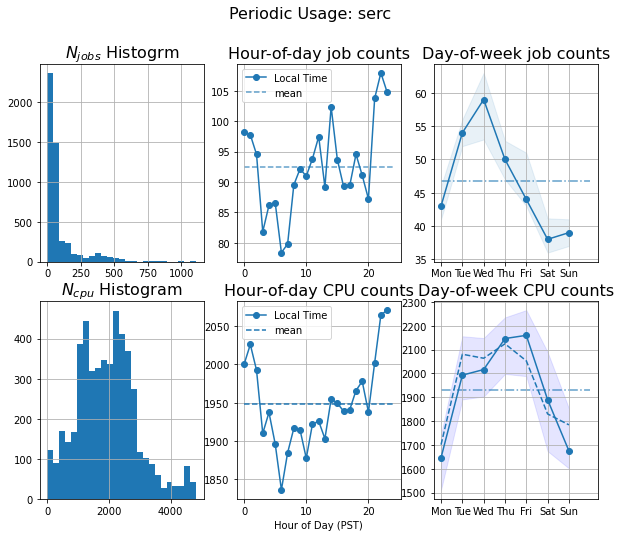

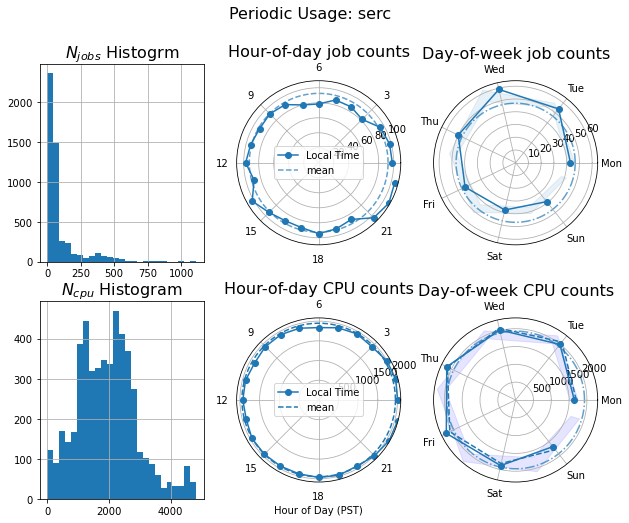

In [35]:
# How to make reports with hpc_lib.SACCT_groups_analyzer_report_handler()
#
serc_report_h = hpc_lib.SACCT_groups_analyzer_report_handler(Short_title='SERC Analytics', Full_title='SERC HPC analytics',
                                                  SACCT_obj=SACCT_obj,
                                                  out_path='output/SERC_analytics_20220121_h',
                                                   tex_filename='SERC_HPC_analytics.tex'
                                                  )
z = serc_report_h.standard_reports_slides(group_name='serc')

#z = serc_report_h.standard_reports_slides(ix=(SACCT_obj.jobs_summary['Group']==b'biondo'), group_name='Biondo')

zz = serc_report_h.HPC_tex_obj.render()
#ix_g_ruthm = numpy.where([SACCT_obj.jobs_summary['User'] ])
#ix_g_ruthm = (SACCT_obj.jobs_summary['Group']=='ruthm')

In [36]:
#SACCT_obj.

In [37]:

#hourlies = SACCT_obj.get_cpu_hours(bin_size=1./24., d_t=1/24., IX=None, verbose=0)
# NOTE: because we have 1/24 d_t and bin_size, this should be equivalent to active_cpus, but it is not
#. actually computed quite the same way.
hourlies = hpc_lib.get_cpu_hours(bin_size=7., d_t=1/24., verbose=0, jobs_summary=SACCT_obj.jobs_summary)

#hourlies = hpc_lib.get_cpu_hours(bin_size=1./24., n_points=None, d_t=1./24., verbose=0, jobs_summary=SACCT_obj.jobs_summary)

print('** hourlies: ', hourlies['cpu_hours'][0:20]*24.)

** hourlies:  [    0.           719.51999997  2447.52000002  4175.52000007
  5903.52000012  7631.52000017  9359.52000022 11087.52000027
 12815.52000032 14543.52000037 16271.52000042 17999.52000047
 19727.52000052 21455.52000058 23183.52000063 24911.52000068
 26639.52000073 28367.52000078 30095.52000083 31823.52000088]


In [38]:
hourlies_cpu_job = hpc_lib.active_jobs_cpu(bin_size=1./24., jobs_summary=SACCT_obj.jobs_summary)
hourlies_cpu_job['N_jobs'][numpy.isnan(hourlies_cpu_job['N_jobs'])] = 0.
hourlies_cpu_job['N_cpu'][numpy.isnan(hourlies_cpu_job['N_cpu'])] = 0.

*** DEBUG: 4368, 0.041666666666666664


In [39]:
print('** ', hourlies_cpu_job.dtype)
print(numpy.isnan(hourlies_cpu_job['N_jobs']).any() )
print(numpy.isnan(hourlies_cpu_job['N_cpu']).any() )
print(numpy.isnan(hourlies_cpu_job['time']).any() )

**  [('time', '>f8'), ('N_jobs', '>f8'), ('N_cpu', '>f8')]
False
False
False


In [40]:
# I don't know why these are not the same length... something to do with how cpu-hours are computed.
print('lens: ', len(hourlies), len(hourlies_cpu_job))

lens:  4363 4368


In [41]:
# NOTE: num2date(0) is a thursday, so datetime.weekday() == (t+3)%7 or (t-4)%7, so t%7 = {2,3} are sat, sun.
ix_wknd   = numpy.logical_and( (hourlies['time'])%7 >= 2., (hourlies['time'])%7 <= 3. )
ix_afters = numpy.logical_or(hourlies['time']%1.<.3 , hourlies['time']%1>.8)
ix_dollies = numpy.logical_and(numpy.invert(ix_wknd), numpy.invert(ix_afters))

In [42]:
ix_w   = numpy.logical_and( (hourlies_cpu_job['time'])%7 >= 2., (hourlies_cpu_job['time'])%7 <= 3. )
#ix_a   = numpy.logical_or(hourlies_cpu_job['time']%1.<.3 , hourlies_cpu_job['time']%1>.8)
ix_a   = numpy.logical_and( numpy.logical_or(hourlies_cpu_job['time']%1.<.33 , hourlies_cpu_job['time']%1>.75),
                           numpy.invert(ix_w))
ix_d   = numpy.logical_and(numpy.invert(ix_w), numpy.invert(ix_a))

In [43]:
print('** ', hourlies['cpu_hours'][0:10])

**  [  0.          29.98       101.98       173.98       245.98000001
 317.98000001 389.98000001 461.98000001 533.98000001 605.98000002]


In [44]:
# print('*** ', SACCT_obj.jobs_summary[0:10])
# print('*** ', SACCT_obj.jobs_summary.dtype)
# print('*** ', SACCT_obj.jobs_summary['Start'][0:10])
#
# what do dates look like? Turns out that the SLURM dates are TZ naive, but in local (PST) time.
# so matplotlib just treats them like UTC, so our treatment should be fine...
dt_str = '2021-12-08T11:05:18'
dt_num = mpd.datestr2num(dt_str)
print(f'** dt_num: {dt_num}')

** dt_num: 18969.46201388889


In [45]:

# compute running averages over a full week for the components:
# dollies (9 to 5)
# after hours (weekdays, not 9 to 5)
# weekends.
ave_bins = 7*24
#
hourlies_cake_total = running_mean(hourlies_cpu_job['N_cpu'], ave_bins)
#
X = hourlies_cpu_job['N_cpu'].copy()
X[numpy.invert(ix_d)] = 0.
hourlies_cake_9to5 = running_mean(X,ave_bins)
#
X = hourlies_cpu_job['N_cpu'].copy()
X[numpy.invert(ix_w)] = 0.
hourlies_cake_wknd = running_mean(X, ave_bins)
#
X = hourlies_cpu_job['N_cpu'].copy()
X[numpy.invert(ix_a)] = 0.
hourlies_cake_afters = running_mean(X, ave_bins)
#

# print('** ', hourlies['cpu_hours'][0:10]*24.)
# print('** ', hourlies_cake_afters[0:100])

In [153]:
dt = dtm.datetime.now()
dt_64 = numpy.datetime64(dt)
#
print('** ', dt.weekday())
print('** ', int((mpd.date2num(dt)+3)%7))
#
print('** ', isinstance(numpy.datetime64(dtm.datetime.now()), dtm.datetime))
#
print('*** ', mpd.date2num(dt), mpd.date2num(dt_64))
#
print('*** ', numpy.mod(numpy.arange(10),2) )

**  2
**  2
**  False
***  19039.72019173935 19039.72019173935
***  [0 1 0 1 0 1 0 1 0 1]


In [46]:
#q_steps = numpy.array([.25, .5, .75, .9])
qs = numpy.array([.25, .5, .75, .9])
print('** ', numpy.sum(hourlies_cpu_job['N_cpu']), numpy.sum(hourlies_cpu_job['N_cpu'][ix_d]),
      numpy.sum(hourlies_cpu_job['N_cpu'][ix_a]), numpy.sum(hourlies_cpu_job['N_cpu'][ix_w]))
#
dtype_qs = [('time', '>i8')] + [(f'q{k+1}', '>f8') for k,x in enumerate(qs)] 
print('** dtype: ', dtype_qs)
periodic_hourly_weekdays_cpus = numpy.zeros((24,), dtype=dtype_qs)
periodic_hourly_weekdays_cpus['time'] = numpy.arange(24)
print('** ', periodic_hourly_weekdays_cpus)
print('** ', periodic_hourly_weekdays_cpus['time'])
#
for k in periodic_hourly_weekdays_cpus['time']:
    # we are really interested in 9to5 activity, but since we're resolving hours, we might as well show 
    #. them. SO, we want to just exclude weekends, then do quantiles on daily slices.
    q_vals = numpy.nanquantile(hourlies_cpu_job['N_cpu'][numpy.logical_and(numpy.invert(ix_w),
                                    (24*(hourlies_cpu_job['time']%1)).astype(int)==k)], qs)
    #print(f'** qs[{k}]: {q_vals}')
    #
    # what is this syntax????
    #periodic_hourly_925_cpus[('q1', 'q2', 'q3')] = q_vals[:]
    #if numpy.isnan(q_vals):
    #    continue
    for j,q in enumerate(q_vals):
        periodic_hourly_weekdays_cpus[f'q{j+1}'][k]=q
print('** **\n', periodic_hourly_weekdays_cpus)

periodic_daily_925_cpus = numpy.zeros((7,), dtype=dtype_qs)
periodic_daily_cpus = numpy.zeros((7,), dtype=dtype_qs)
periodic_daily_925_cpus['time'] = numpy.arange(7)
periodic_daily_cpus['time'] = numpy.arange(7)
#
# daily usage:
for k in periodic_daily_cpus['time']:
    # here, we want do do quantiles on daily slices. Again, our principal interest is
    #. 9to5 activity, so exclude after-hours (t_am > t < t_pm), but include weekends. 
#    q_vals_925 = numpy.nanquantile(hourlies_cpu_job['N_cpu'][numpy.logical_and(numpy.invert(ix_d),
#                                    (((hourlies_cpu_job['time']+3)%7)).astype(int)==k)], qs)
    # ix_a   = numpy.logical_and( numpy.logical_or(hourlies_cpu_job['time']%1.<.33 , hourlies_cpu_job['time']%1>.75),
    #                       numpy.invert(ix_w))
    ix_925 = numpy.logical_and(numpy.logical_and((hourlies_cpu_job['time']%1. >= .33),
                                             (hourlies_cpu_job['time']%1 <= .75)),
                           (((hourlies_cpu_job['time']+3)%7).astype(int)==k)
                          )
    #X = hourlies_cpu_job['N_cpu'][ix]
    #print('*** sum(ix): ', numpy.sum(ix) )
    q_vals_925 = numpy.nanquantile(hourlies_cpu_job['N_cpu'][ix_925], qs)
    #
#    q_vals     = numpy.nanquantile(hourlies_cpu_job['N_cpu'][numpy.logical_and(numpy.invert(ix_a),
#                                    (((hourlies_cpu_job['time']+3)%7)).astype(int)==k)], qs)
    q_vals     = numpy.nanquantile(hourlies_cpu_job['N_cpu'][(((hourlies_cpu_job['time']+3)%7)).astype(int)==k], qs)

    #                                                             
    #print(f'** ** q_vals_925[{k}]: {q_vals_925}')
    for j,q in enumerate(q_vals):
        periodic_daily_cpus[f'q{j+1}'][k]=q
    for j,q in enumerate(q_vals_925):
        periodic_daily_925_cpus[f'q{j+1}'][k]=q

**  8516126.0 3065747.0 4298061.0 1152318.0
** dtype:  [('time', '>i8'), ('q1', '>f8'), ('q2', '>f8'), ('q3', '>f8'), ('q4', '>f8')]
**  [( 0, 0., 0., 0., 0.) ( 1, 0., 0., 0., 0.) ( 2, 0., 0., 0., 0.)
 ( 3, 0., 0., 0., 0.) ( 4, 0., 0., 0., 0.) ( 5, 0., 0., 0., 0.)
 ( 6, 0., 0., 0., 0.) ( 7, 0., 0., 0., 0.) ( 8, 0., 0., 0., 0.)
 ( 9, 0., 0., 0., 0.) (10, 0., 0., 0., 0.) (11, 0., 0., 0., 0.)
 (12, 0., 0., 0., 0.) (13, 0., 0., 0., 0.) (14, 0., 0., 0., 0.)
 (15, 0., 0., 0., 0.) (16, 0., 0., 0., 0.) (17, 0., 0., 0., 0.)
 (18, 0., 0., 0., 0.) (19, 0., 0., 0., 0.) (20, 0., 0., 0., 0.)
 (21, 0., 0., 0., 0.) (22, 0., 0., 0., 0.) (23, 0., 0., 0., 0.)]
**  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
** **
 [( 0, 1299.25, 2008. , 2670.75, 3478.5)
 ( 1, 1262.  , 1982. , 2653.  , 3370.6)
 ( 2, 1278.  , 1899. , 2566.  , 3192. )
 ( 3, 1246.5 , 1937. , 2538.25, 3116. )
 ( 4, 1211.  , 1880. , 2471.5 , 3049.5)
 ( 5, 1201.  , 1923. , 2525.  , 3046.2)
 ( 6, 1181.5 , 1903.5, 24

<ipython-input-47-a75c7ec133d5>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


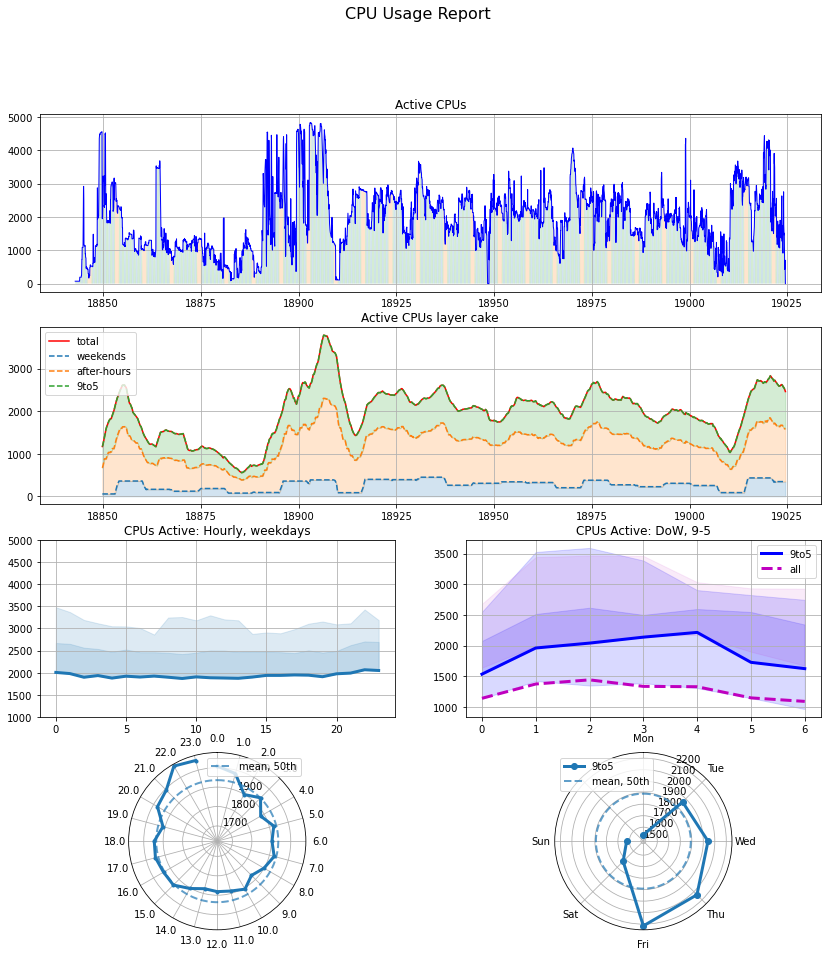

In [47]:
#print('** ', ix_dollies[0:100])
fg = plt.figure(figsize=(14,15))
n_cols = 2
n_rws  = 4
ax1 = plt.subplot(n_rws,1,1)
ax2 = plt.subplot(n_rws,1,2, sharex=ax1)
ax3 = plt.subplot(n_rws,n_cols,5)
ax4 = plt.subplot(n_rws,n_cols,6)
ax5 = plt.subplot(n_rws,n_cols,7, projection='polar')
ax6 = plt.subplot(n_rws,n_cols,8, projection='polar')
#
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
#
fg.suptitle('CPU Usage Report', size=16)
ax1.set_title('Active CPUs')
ax2.set_title('Active CPUs layer cake')
ax3.set_title('CPUs Active: Hourly, weekdays')
ax4.set_title('CPUs Active: DoW, 9-5')
#
# ix=numpy.logical_and( T%1.>.3 , T%1<.8, (T-4)%7)
# ax.plot(hourlies['time'], hourlies['cpu_hours'])
# ax.plot(hourlies['time'][ix], hourlies['cpu_hours'][ix], ls='', marker='.')
ax1.plot(hourlies_cpu_job['time'], hourlies_cpu_job['N_cpu'], color='b', lw=1.)
#ax1.fill_between(hourlies_cpu_job['time'], 0., hourlies_cpu_job['N_cpu'], color='b', alpha=.2, zorder=1)
X = hourlies_cpu_job['N_cpu'].copy()
X[numpy.invert(ix_d)]=0.
ax1.fill_between(hourlies_cpu_job['time'], 0., X, alpha=.2)
#
X = hourlies_cpu_job['N_cpu'].copy()
X[numpy.invert(ix_w)]=0.
ax1.fill_between(hourlies_cpu_job['time'], 0., X, alpha=.2)
#
X = hourlies_cpu_job['N_cpu'].copy()
X[numpy.invert(ix_a)]=0.
X[ix_w]=0.
ax1.fill_between(hourlies_cpu_job['time'], 0., X, alpha=.2)
#

# ax1.plot(hourlies_cpu_job['time'][ix_d], hourlies_cpu_job['N_cpu'][ix_d], ls='', marker='.')
# ax1.plot(hourlies_cpu_job['time'][ix_w], hourlies_cpu_job['N_cpu'][ix_w], ls='', marker='.')
# ax1.plot(hourlies_cpu_job['time'][ix_a], hourlies_cpu_job['N_cpu'][ix_a], ls='', marker='.')
#
T = hourlies_cpu_job['time']
ln, = ax2.plot(T[ave_bins-1:], hourlies_cake_total, ls='-', color='r', label='total')
#ax2.plot(T, hourlies['cpu_hours'], ls='-', marker='')
X = hourlies_cake_wknd.copy()
ln, = ax2.plot(T[ave_bins-1:], X, ls='--', label='weekends')
clr = ln.get_color()
ax2.fill_between(T[ave_bins-1:], 0., X, color=clr, alpha=.2 )
#
X0 = X.copy()
X += hourlies_cake_afters
ln, = ax2.plot(T[ave_bins-1:], X, ls='--', label='after-hours')
clr = ln.get_color()
ax2.fill_between(T[ave_bins-1:], X0, X, color=clr, alpha=.2 )
#
X0 = X.copy()
X += hourlies_cake_9to5
ln, = ax2.plot(T[ave_bins-1:], X, ls='--', marker='', label='9to5')
clr = ln.get_color()
ax2.fill_between(T[ave_bins-1:], X0, X, color=clr, alpha=.2 )
#
ax2.legend(loc=0)
#
ln, = ax3.plot(periodic_hourly_weekdays_cpus['time'], periodic_hourly_weekdays_cpus['q2'], lw=3)
clr = ln.get_color()
ax3.fill_between(periodic_hourly_weekdays_cpus['time'], periodic_hourly_weekdays_cpus['q2'],
                 periodic_hourly_weekdays_cpus['q3'], color=clr, alpha=.15 )
ax3.fill_between(periodic_hourly_weekdays_cpus['time'], periodic_hourly_weekdays_cpus['q2'],
                 periodic_hourly_weekdays_cpus['q4'], color=clr, alpha=.15 )

xx = numpy.min(numpy.append([1000], periodic_hourly_weekdays_cpus['q1']))
ax3.set_ylim(xx, 5000)
#
X = periodic_daily_925_cpus.copy()
ax4.plot(X['time'], X['q2'], lw=3, color='b', label='9to5')
ax4.fill_between(X['time'], X['q2'], X['q3'], color='b', alpha=.15 )
ax4.fill_between(X['time'], X['q1'], X['q4'], color='b', alpha=.15 )
X = periodic_daily_cpus
ax4.plot(X['time'], X['q1'], lw=3, color='m', ls='--', label='all')
ax4.fill_between(X['time'], X['q2'], X['q4'], color='m', alpha=.08)
ax4.legend(loc=0)
#
ax5.set_theta_direction(-1)
ax5.set_theta_offset(math.pi/2.0)
X = periodic_hourly_weekdays_cpus['time'].copy()*scipy.constants.pi*2.0/float(len(periodic_hourly_weekdays_cpus))
ln, = ax5.plot(X, periodic_hourly_weekdays_cpus['q2'], lw=3, marker='.')
clr = ln.get_color()
ax5.plot(numpy.linspace(0., math.pi*2., 100), numpy.ones(100)*numpy.mean(periodic_hourly_weekdays_cpus['q2']),
         ls='--', lw=2., color=clr, alpha=.7, label='mean, 50th' )
ax5.set_xticks(numpy.arange(0., math.pi*2., math.pi*2/24.))
ax5.set_xticklabels(numpy.arange(0,24, 1.))
y_min = .5*(numpy.max(periodic_hourly_weekdays_cpus['q1'])+numpy.min(periodic_hourly_weekdays_cpus['q2']))
ax5.set_ylim(y_min, )
ax5.grid()
ax5.legend(loc='upper right')
#
# TODO: figure out phase of DoW circle-plot.
ax6.set_theta_direction(-1)
ax6.set_theta_offset(math.pi/2.0)
X = periodic_daily_925_cpus.copy()
ln, = ax6.plot(X['time']*math.pi*2.0/float(len(X)+1.), X['q2'], lw=3, marker='o', label='9to5')
clr = ln.get_color()
ax6.plot(numpy.linspace(0., math.pi*2., 100), numpy.ones(100)*numpy.mean(X['q2']), ls='--', lw=2., 
         color=clr, alpha=.7 , label='mean, 50th')
ax6.set_xticks=numpy.arange(0., math.pi*2., math.pi*2./7.)
ax6.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
y_min = .5*(numpy.max(X['q1']) + numpy.min(X['q2']))
ax6.set_ylim(y_min, )
ax6.grid()
ax6.legend(loc='upper left')


In [48]:
print('** ', hourlies['cpu_hours'][0:10])
print('** ', hourlies_cake_9to5[0:10])



**  [  0.          29.98       101.98       173.98       245.98000001
 317.98000001 389.98000001 461.98000001 533.98000001 605.98000002]
**  [501.6547619 501.6547619 501.6547619 501.6547619 501.6547619 501.6547619
 501.6547619 501.6547619 501.6547619 501.6547619]


In [49]:
for t in hourlies['time'][0:250]:
    d = mpd.num2date(t)
    print('** time: {}: hour: {}, weekday: {}/{}/{}::{}'.format(t, d.hour, d.weekday(), int(t%7), 
                                                                int(t+3)%7, int(t-4)%7 ))

** time: 18842.791666666664: hour: 19, weekday: 1/5/1::1
** time: 18842.833333333332: hour: 20, weekday: 1/5/1::1
** time: 18842.875: hour: 21, weekday: 1/5/1::1
** time: 18842.916666666668: hour: 22, weekday: 1/5/1::1
** time: 18842.958333333336: hour: 23, weekday: 1/5/1::1
** time: 18843.000000000004: hour: 0, weekday: 2/6/2::2
** time: 18843.04166666667: hour: 1, weekday: 2/6/2::2
** time: 18843.08333333334: hour: 2, weekday: 2/6/2::2
** time: 18843.125000000007: hour: 3, weekday: 2/6/2::2
** time: 18843.166666666675: hour: 4, weekday: 2/6/2::2
** time: 18843.208333333343: hour: 5, weekday: 2/6/2::2
** time: 18843.25000000001: hour: 6, weekday: 2/6/2::2
** time: 18843.29166666668: hour: 7, weekday: 2/6/2::2
** time: 18843.333333333347: hour: 8, weekday: 2/6/2::2
** time: 18843.375000000015: hour: 9, weekday: 2/6/2::2
** time: 18843.416666666682: hour: 10, weekday: 2/6/2::2
** time: 18843.45833333335: hour: 11, weekday: 2/6/2::2
** time: 18843.50000000002: hour: 12, weekday: 2/6/2::2

In [61]:
import sys
import os
os.path.join('abc', 'def')
#os.path.append

'abc/def'

*** DEBUG: 4368, 0.041666666666666664
*** DEBUG: q_vals [1140. 1641. 2171. 2681.]
*** DEBUG: q_vals [1373.5 1992.  2531.5 3444.6]
*** DEBUG: q_vals [1441.  2018.  2569.  3468.6]
*** DEBUG: q_vals [1334.75 2154.   2642.75 3463.5 ]
*** DEBUG: q_vals [1329. 2175. 2654. 3035.]
*** DEBUG: q_vals [1147.  1900.5 2506.5 2934. ]
*** DEBUG: q_vals [1089.75 1674.   2383.   2928.9 ]
** ** DEBUG:  ['18825', '18850', '18875', '18900', '18925', '18950', '18975', '19000', '19025', '19050']


/Users/myoder96/Codes/HPC_analytics/hpc_reports.py:239: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_reports.py:284: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


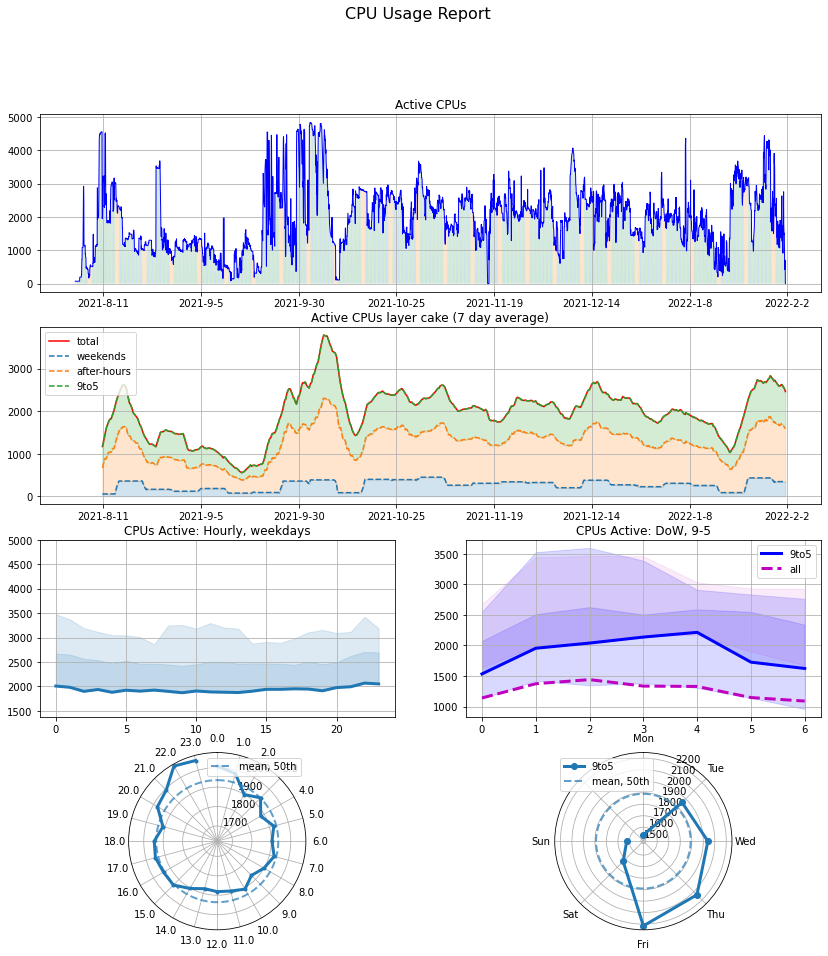

In [62]:

rpt = hpc_reports.SACCT_report_handler(SACCT_obj=SACCT_obj, out_path='output/SERC_analytics')
#
zz = rpt.cpu_hourly_activity_report(fout_path_name='')

#### Wait Stats figure/report:
- Do a wait-time timeseries (just to see how it looks), maybe with some averaging.
- Wait time quantiles, again by day, hour, 9to5, and for a few ranges of n_cpu.

In [ ]:
wait_stats      = SACCT_obj.get_wait_stats(qs=[.25, .5, .75, .9])
for col in wait_stats.dtype.names[1:]:
    wait_stats[col]*=24.
#wait_stats_ncpu = SACCT_obj.get_wait_times_per_ncpu()
wait_times = 24.*(SACCT_obj.jobs_summary['Start'] - SACCT_obj.jobs_summary['Submit'])
#

In [165]:
wait_times_per_dow = hpc_lib.day_of_week_distribution(time=SACCT_obj.jobs_summary['Submit'], Y=wait_times)
wait_times_per_hod = hpc_lib.hour_of_day_distribution(time=SACCT_obj.jobs_summary['Submit'], Y=wait_times)

[(0, 0.01527778, 0.07444444, 0.23722222, 0.46166667)
 (1, 0.00666667, 0.03527778, 0.12083333, 0.34361111)
 (2, 0.01243056, 0.09111111, 0.41388889, 4.37358333)
 (3, 0.01861111, 0.10527778, 0.37277778, 0.90638889)
 (4, 0.00833333, 0.04472222, 0.25722222, 0.68111111)
 (5, 0.00305556, 0.00777778, 0.025     , 0.08888889)
 (6, 0.00388889, 0.01027778, 0.02111111, 0.035     )]


***  [0.00472222 0.01694444 0.06055556 0.28444444]
*** wait time quantiles: 
** q[0.25]: 0.28333333146292716 
** q[0.5]: 1.016666668583639 
** q[0.76]: 3.633333334000781 
** q[0.9]: 17.066666669561528 
*** mean: 0.39142411804322513


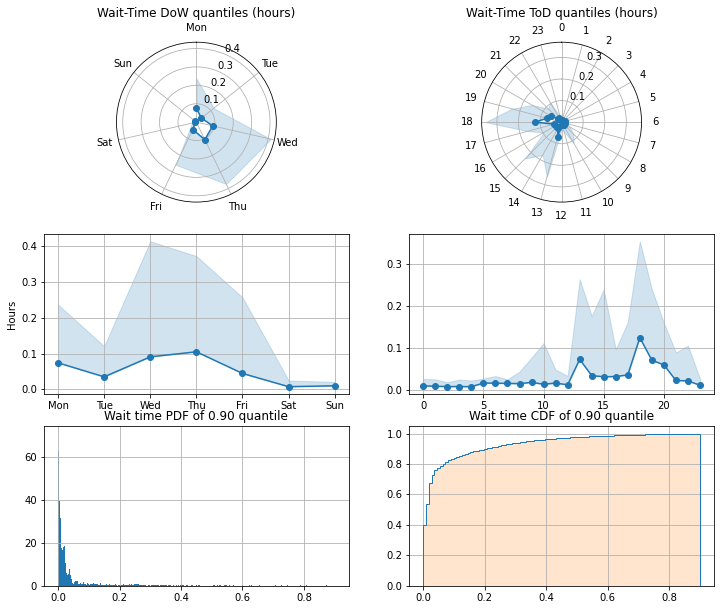

In [184]:
# Wait stats on serc are basically nothing. Let's see if we can get something interesting for
# ncpus: <=10, 10<n<100, n>100\
#
# kx_wait_10 = SACCT_obj.jobs_summary['NCPUS']<=10
# kx_wait_100 = numpy.logical_and(SACCT_obj.jobs_summary['NCPUS']>10,  SACCT_obj.jobs_summary['NCPUS']<=100)
# kx_wait_101 = SACCT_obj.jobs_summary['NCPUS']>100
#
fg = plt.figure(figsize=(12,10))
ax1a = plt.subplot(3,2,1, projection='polar')
ax1a.set_theta_direction(-1)
ax1a.set_theta_offset(math.pi/2.0)
ax1a.set_title('Wait-Time DoW quantiles (hours)')
#
ax1b = plt.subplot(3,2,2, projection='polar')
ax1b.set_theta_direction(-1)
ax1b.set_theta_offset(math.pi/2.0)
ax1b.set_title('Wait-Time ToD quantiles (hours)')
#
#ax2 = plt.subplot(3,1,2)
ax2a = plt.subplot(3,2,3)
ax2b = plt.subplot(3,2,4)

ax3 = plt.subplot(3,2,5)
ax4 = plt.subplot(3,2,6)
#
q_ps = [.25, .5, .76, .9]
ix = wait_times<qs[3]
#
X_dow = wait_times_per_dow['DoW']*math.pi*2./7.
ln, = ax1a.plot(X_dow, wait_times_per_dow['q2'], ls='-', marker='o')
clr = ln.get_color()
ax1a.fill_between(X_dow, wait_times_per_dow['q2'], wait_times_per_dow['q3'], color=clr, alpha=.2)
ax1a.set_xticks(X_dow)
ax1a.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
#
X_hod = wait_times_per_hod['hour']*math.pi*2./float(len(wait_times_per_hod))
ln, = ax1b.plot(X_hod, wait_times_per_hod['q2'], ls='-', marker='o')
clr = ln.get_color()
ax1b.fill_between(X_hod, wait_times_per_hod['q2'], wait_times_per_hod['q3'], color=clr, alpha=.2)
ax1b.set_xticks(X_hod )
ax1b.set_xticklabels(numpy.arange(0,24,1))
#
X_dow = wait_times_per_dow['DoW']
ln, = ax2a.plot(X_dow, wait_times_per_dow['q2'], ls='-', marker='o')
clr = ln.get_color()
ax2a.fill_between(X_dow, wait_times_per_dow['q2'], wait_times_per_dow['q3'], color=clr, alpha=.2)
ax2a.set_xticks(numpy.arange(0, 7) )
ax2a.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2a.set_ylabel('Hours')
#
X_hod = wait_times_per_hod['hour']
ln, = ax2b.plot(X_hod, wait_times_per_hod['q2'], ls='-', marker='o')
clr = ln.get_color()
ax2b.fill_between(X_hod, wait_times_per_hod['q2'], wait_times_per_hod['q3'], color=clr, alpha=.2)

qs_wait = numpy.quantile(wait_times[numpy.invert(numpy.isnan(wait_times))], q_ps)
print('*** ', qs_wait)
print('*** wait time quantiles: ')
for q_p, q_v in zip(q_ps, qs_wait):
    print(f'** q[{q_p}]: {q_v*60.} ')
print('*** mean: {}'.format(numpy.mean(wait_times[numpy.invert(numpy.isnan(wait_times))])))
#

h1 = ax3.hist(wait_times[ix], bins=1000, density=True)
#ax3.set_xlim(0., 1.)
ax3.set_title(f'Wait time PDF of {q_ps[3]:.2f} quantile')
#
h2 = ax4.hist(wait_times[ix], bins=100, cumulative=True, density=True, histtype='step')
h2 = ax4.hist(wait_times[ix], bins=100, cumulative=True, density=True, histtype='stepfilled', alpha=.2)
#ax4.set_xlim(0, 1.)
ax4.set_title(f'Wait time CDF of {q_ps[3]:.2f} quantile')
#
for ax in (ax2a, ax2b, ax3, ax4):
    ax.grid()



In [ ]:
# let's just write explicit functions for periodic usage of cpus, jobs, other-stuff-too?
# We could use the existing tools to modulus-bin time-series, but I think it won't cost that much
# to just do it explicitly and (more) exactly. Trying to match up

In [ ]:

print('** ', wait_times[0:15])

In [73]:
print('** ', wait_stats[0:10])
print('** ', wait_stats.dtype.names)
print('** ', wait_stats.qs)

**  [( 1, 0.01047056, 0.00059028, 0.17756692, 0., 14.25418981, 1.73611112e-04, 0.00059028, 0.00136574, 0.00790856)
 ( 2, 0.00301577, 0.00034722, 0.015611  , 0.,  0.53581019, 8.10185156e-05, 0.00034722, 0.00288194, 0.01064815)
 ( 3, 0.00379575, 0.00162037, 0.00566889, 0.,  0.06586806, 6.48148147e-04, 0.00162037, 0.00444444, 0.00988426)
 ( 4, 0.11811609, 0.00078704, 0.22506307, 0.,  2.10113426, 1.62037039e-04, 0.00078704, 0.14965278, 0.45671065)
 ( 5, 0.00073548, 0.00017361, 0.00179863, 0.,  0.02165509, 5.78703693e-05, 0.00017361, 0.00051215, 0.00181134)
 ( 6, 0.00181562, 0.00039931, 0.00557592, 0.,  0.07420139, 8.10185165e-05, 0.00039931, 0.0023235 , 0.00381366)
 ( 7, 0.15475235, 0.00277199, 0.21156322, 0.,  1.10195602, 4.68750000e-04, 0.00277199, 0.28313657, 0.48548958)
 ( 8, 0.01735906, 0.00488426, 0.05974291, 0.,  0.92030093, 1.46990741e-03, 0.00488426, 0.01400463, 0.02766204)
 ( 9, 0.00215338, 0.00037616, 0.01087093, 0.,  0.10699074, 1.27314815e-04, 0.00037616, 0.00128472, 0.0031481